In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from random import gauss
from random import seed

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Questions:  

* What's the relation between seasonality and lag correlation (autocorrelation)? Does it make sense to use autocorrelation to assess seasonality when we have a trend?
* If we set `seasonal_order=(0, 0, 0, 0)` is SARIMAX exactly the same as SARIMA?  
* SARIMAX `results.get_prediction()` returns a `statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper` object but looking to the [documentation](http://www.statsmodels.org/dev/generated/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.get_prediction.html#statsmodels.tsa.statespace.mlemodel.MLEResults.get_prediction) I was expecting a numpy array!
* 

# BLU04 - Pandas for Timeseries

In [2]:
data = pd.read_csv('BLU04 - Time Series Concepts/data/bitcoin.csv')

In [3]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2017-01-01 00:00:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
1,2017-01-01 00:01:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2,2017-01-01 00:02:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
3,2017-01-01 00:03:00,973.36,973.36,973.36,973.36,0.040000,38.934400,973.360000
4,2017-01-01 00:04:00,973.36,973.40,973.36,973.39,5.458800,5313.529708,973.387871


**Series `Timestamp` is type object!**

In [4]:
print(data.Timestamp.dtype)

object


In [5]:
data.Timestamp.head()

0    2017-01-01 00:00:00
1    2017-01-01 00:01:00
2    2017-01-01 00:02:00
3    2017-01-01 00:03:00
4    2017-01-01 00:04:00
Name: Timestamp, dtype: object

### Convert to `datetime`

In [6]:
data.Timestamp = pd.to_datetime(data.Timestamp, infer_datetime_format=True)

In [7]:
data.Timestamp.head()

0   2017-01-01 00:00:00
1   2017-01-01 00:01:00
2   2017-01-01 00:02:00
3   2017-01-01 00:03:00
4   2017-01-01 00:04:00
Name: Timestamp, dtype: datetime64[ns]

### Computations on `datetime`

**Now we can use `pandas.Series` methods and `.dt` accessor. For example...**

[Pandas Time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)  
[Pandas .dt accessor](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#dt-accessor)

- `.max()`
- `.cumsum()`
- `.cummax()`
- `.rolling()`
- `.diff()`
- `.pct_change()`

In [8]:
data.Timestamp.max()

Timestamp('2018-03-27 00:00:00')

In [9]:
data.Timestamp.dt.minute.head()

0    0
1    1
2    2
3    3
4    4
Name: Timestamp, dtype: int64

Converting to **time since epoch** (number of seconds that have elapsed since 00:00:00, 1 January 1970 UTC) and back.

In [10]:
tse_time = data.Timestamp.astype('int64')
tse_time.head()

0    1483228800000000000
1    1483228860000000000
2    1483228920000000000
3    1483228980000000000
4    1483229040000000000
Name: Timestamp, dtype: int64

In [11]:
pd.to_datetime(tse_time).head()

0   2017-01-01 00:00:00
1   2017-01-01 00:01:00
2   2017-01-01 00:02:00
3   2017-01-01 00:03:00
4   2017-01-01 00:04:00
Name: Timestamp, dtype: datetime64[ns]

### Selecting  

Timestamp is the pandas equivalent of python’s Datetime and is used for the entries that make up a DatetimeIndex.  
See pandas [timestamp documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)

Set Timestamp as the index.

In [12]:
data = data.set_index('Timestamp',drop=True)
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-01-01 00:00:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2017-01-01 00:01:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2017-01-01 00:02:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2017-01-01 00:03:00,973.36,973.36,973.36,973.36,0.040000,38.934400,973.360000
2017-01-01 00:04:00,973.36,973.40,973.36,973.39,5.458800,5313.529708,973.387871


**When the index is datetime, it should always be sorted!**

In [13]:
data = data.sort_index()

In [14]:
data[data.index.month == 6].head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2017-06-01 00:00:00,2303.61,2304.15,2303.12,2304.02,3.666929,8448.703295,2304.026682
2017-06-01 00:01:00,2303.88,2304.15,2302.00,2302.00,4.872337,11223.396828,2303.493691
2017-06-01 00:02:00,2303.73,2304.06,2302.05,2303.32,6.266425,14436.511779,2303.787616
2017-06-01 00:03:00,2303.31,2303.31,2302.08,2303.09,2.058130,4740.119791,2303.119788
2017-06-01 00:04:00,2303.09,2307.60,2303.09,2307.60,39.879237,91955.757727,2305.855474


In [15]:
data['01/17/2018'].head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-01-17 00:00:00,11570.01,11570.01,11570.00,11570.00,37.374867,4.324275e+05,11570.006518
2018-01-17 00:01:00,11570.01,11699.00,11550.00,11627.09,82.549136,9.575156e+05,11599.340993
2018-01-17 00:02:00,11605.00,11700.22,11550.00,11624.00,78.062113,9.092036e+05,11647.181988
2018-01-17 00:03:00,11624.00,11790.00,11603.14,11725.38,92.075967,1.081329e+06,11743.878594
2018-01-17 00:04:00,11725.52,11800.00,11725.51,11799.99,97.790853,1.153220e+06,11792.718569


In [16]:
data['01/17/2018 1:30PM':'01/17/2018 1:40PM']

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-01-17 13:30:00,10320.37,10392.96,10320.36,10389.76,18.829533,194664.293210,10338.243544
2018-01-17 13:31:00,10389.76,10389.76,10310.00,10310.01,13.012326,134782.335550,10358.050813
2018-01-17 13:32:00,10310.00,10347.19,10310.00,10331.86,6.500988,67075.196183,10317.693217
2018-01-17 13:33:00,10331.87,10347.17,10331.87,10339.15,8.774058,90744.731937,10342.389840
2018-01-17 13:34:00,10339.14,10350.01,10330.00,10330.00,17.040271,176266.835200,10344.133215
2018-01-17 13:35:00,10330.00,10330.01,10300.00,10309.24,24.539315,253384.119570,10325.639333
2018-01-17 13:36:00,10309.24,10331.00,10280.00,10327.65,9.886690,101939.982550,10310.830554
2018-01-17 13:37:00,10327.64,10343.14,10327.64,10343.14,3.986264,41195.916036,10334.468167
2018-01-17 13:38:00,10343.13,10343.13,10281.01,10290.50,9.228567,95307.671569,10327.461751


### Resampling  

[pandas resampling](https://pandas.pydata.org/pandas-docs/stable/reference/resampling.html)  
[DataFrame.resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html#pandas.DataFrame.resample)

**1. Resample to get a resampler object**

In [17]:
data.Open.resample('M')

DatetimeIndexResampler [freq=<MonthEnd>, axis=0, closed=right, label=right, convention=start, base=0]

**2. To the resampler object we apply whatever computation is needed:**
- `.count()`
- `.first()`
- `.nunique()`
- `.max()`
- `.mean()`
- `.sum()`
- `.std()`
- `.median()`
- `quantile.()`
- ...


In [18]:
data.Open.resample('M').mean()

Timestamp
2017-01-31      913.900487
2017-02-28     1063.098797
2017-03-31     1136.307935
2017-04-30     1215.875404
2017-05-31     1904.348628
2017-06-30     2618.208685
2017-07-31     2496.632774
2017-08-31     3836.768040
2017-09-30     4110.907916
2017-10-31     5292.596445
2017-11-30     7786.211433
2017-12-31    15106.235051
2018-01-31    12876.412886
2018-02-28     9384.386674
2018-03-31     9322.472714
Freq: M, Name: Open, dtype: float64

### Multi-index  

MultiIndex / advanced indexing [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

In [19]:
food = pd.read_csv('BLU04 - Time Series Concepts/data/food.csv')
food.head()

,Store,Product,Price,Quality
0,Incontinente,Apples,3.0,2.0
1,Incontinente,Bananas,2.0,4.0
2,Incontinente,Rice,1.0,3.0
3,Incontinente,Olives,4.0,2.0
4,Dingo Poce,Apples,2.0,2.0


In [20]:
food = food.set_index(['Store', 'Product'])
food.head()

Price  Quality
Store        Product                
Incontinente Apples     3.0      2.0
             Bananas    2.0      4.0
             Rice       1.0      3.0
             Olives     4.0      2.0
Dingo Poce   Apples     2.0      2.0

**Always, always, sort the indexes in a multi-index Dataframe.**

In [21]:
food = food.sort_index()
food

Price  Quality
Store        Product                 
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Dog food    7.0      1.0
             Rice        1.0      4.0
Dumbo        Apples      2.0      3.0
             Dog food    1.0      2.0
             Rice        5.0      4.0
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Olives      4.0      2.0
             Rice        1.0      3.0

### Selecting in multi-index  

In [22]:
food.loc[(slice(None), slice('Apples', 'Apples')), 'Price']

Store         Product
Dingo Poce    Apples     2.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
Name: Price, dtype: float64

In [23]:
idx = pd.IndexSlice
food.loc[idx[: , 'Apples'], 'Price']

Store         Product
Dingo Poce    Apples     2.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
Name: Price, dtype: float64

In [24]:
df = pd.DataFrame({'col1':[1,3,5], 'col2':[2,1,7]})
df

,col1,col2
0,1,2
1,3,1
2,5,7


In [25]:
df[0:1]

,col1,col2
0,1,2


## Seasonal decomposition  

Time series can be thought as a (linear or non-linear) composition of 4 components: **trend**, **cyclical**, **seasonal** and **irregular**

$Y_t = Trend + Seasonal + Cyclical + residual$,  

or

$Y_t = Trend \cdot Seasonal \cdot Cyclical \cdot residual$,  

or yet another non-linear combination of all four. Each one of the previous four components is itself also a time series.  

In order to understand these concepts, let's look at a dataset with [monthly totals of a US airline passangers from 1949 to 1960](https://www.kaggle.com/chirag19/air-passengers)

In [26]:
# Read csv file
airlines = pd.read_csv('BLU05 - Classical Time Series Models/data/international-airline-passengers.csv',
                       header=0,
                       names = ['Month', 'thousands of passengers'])

# drop last line
airlines = airlines.dropna()

# month as index
airlines.Month = pd.to_datetime(airlines.Month)
airlines = airlines.set_index('Month')

#convert to series
airlines = airlines['thousands of passengers']

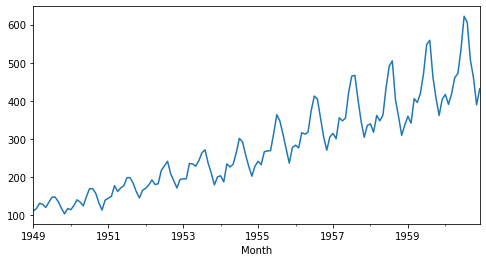

In [27]:
airlines.plot(figsize=(8, 4));

**Trend**

The trend is the component of the time series that allows us to see if, overall, the dependent variable we are observing is increasing or decreasing, without taking into consideration local flutuations.  

The first thing you probably notice in the passengers time series is that, in general, the *passengers are increasing* even though there are anual peaks.  

There are different approaches to visualize the trend, like:
* a simple linear regression;
* the moving average;

In [28]:
lr = LinearRegression()

y = airlines.values.reshape(-1,1)
X = np.array(range(y.shape[0])).reshape(-1,1)
lr.fit(X, y)

linear_trend = pd.Series(lr.predict(X).reshape(-1,), index=airlines.index)

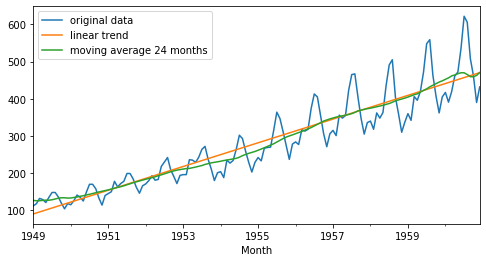

In [29]:
airlines.plot(label="original data", figsize=(8, 4))
linear_trend.plot(label="linear trend")
airlines.rolling(24,  min_periods=12, center=True).mean().plot(label="moving average 24 months")
plt.legend();

**Seasonal**

Unlike the cyclical component, the seasonal component changes at a fixed rate. For example, the bookings in hotels in certain cities have well known maxima (Summer) and minima (Winter).  

In our time series we can see yearly minima and maxima approximately in the same months.

Auto-correlation may help to identify seasonal patterns. For example, if there is a yeraly seasonality then auto-correlation should be higher with $lag = 12$ and lower in between.

In [30]:
corrs = {}

for lag in range(13):
    corrs[lag] = airlines.corr(airlines.shift(lag))

pd.Series(corrs)

0     1.000000
1     0.960195
2     0.895675
3     0.837395
4     0.797735
5     0.785943
6     0.783919
7     0.784592
8     0.792215
9     0.827852
10    0.882713
11    0.949702
12    0.990527
dtype: float64

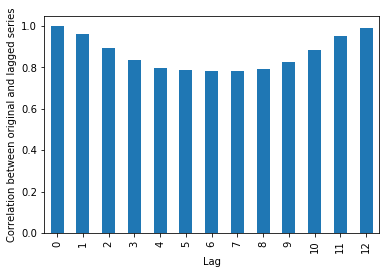

In [31]:
pd.Series(corrs).plot(kind='bar')
plt.xlabel('Lag')
plt.ylabel('Correlation between original and lagged series')
plt.show();

**Cyclical**

The cyclical component is a time series that exhibits a behavior that **repeats in non-regular time intervals**. For example, the performance of the world economy in the 20st century would exhibit a strong cyclical component with non-regular cycles (remember the crisis at the 80's and 2007).

**Residual**

After accounting for all the previous components, the remaining component, called *irregular* or *residual*, won't have any pattern. This part of the time series is considered noise. It is used in several modelling techniques in order to check if a better model can be created.

# BLU05 - Classical Time Series Models  

So far we have learned fundamental concepts to start modelling time series, now we'll finally learn how to actually model them. For that, we're going to dive a bit deeper into their components using a very useful library: _statsmodels_.  

We will use StatsModels extensively. Statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration

(see StatsModels' [documentation](https://www.statsmodels.org/stable/index.html)).

`from statsmodels.tsa.seasonal import seasonal_decompose`

### Trend and seasonal components using [seasonal_decompose()](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).

<a id="multiplicative_or_additive"></a>
First...how do we know if our time series is **additive or multiplicative?**

* **Additive:** if the magnitude of the seasonal fluctuations (variation around the trend-cycle) does not vary with the level of the time series.
* **Multiplicative:** when the variation in the seasonal pattern appears to be proportional to the level of the time series.


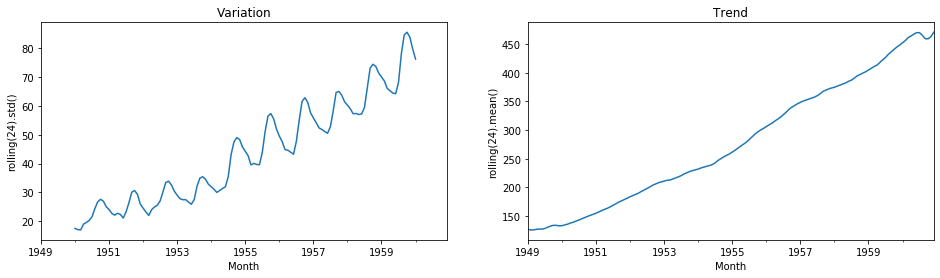

In [32]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
airlines.rolling(24, center=True).std().plot()
plt.ylabel('rolling(24).std()')
plt.title('Variation')

plt.subplot(122)
airlines.rolling(24,  min_periods=12, center=True).mean().plot(label="moving average 24 months")
plt.ylabel('rolling(24).mean()')
plt.title('Trend')
plt.show()

Or in the same figure...

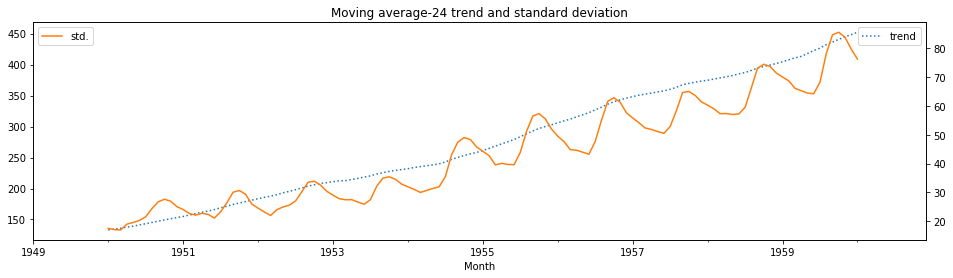

In [33]:
airlines.rolling(24, center=True).mean().plot(label='trend', ls=':')
plt.legend(loc='upper left')
airlines.rolling(24, center=True).std().plot(figsize=(16, 4), label='std.', secondary_y=True)
plt.title('Moving average-24 trend and standard deviation')
plt.legend(loc='upper left')
plt.show()

In our case the standard deviation increases as the trend increases, which means that the time series is multiplicative.  

**A commom way to make the time series additive is to apply the log transformation.** The trend continues to be increasing but the standard deviation stabilizes around an average value.

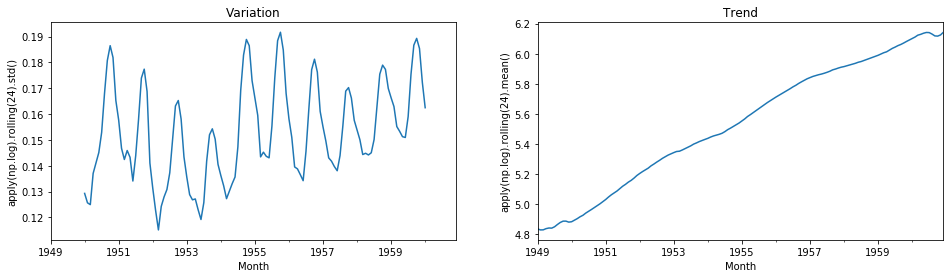

In [34]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
airlines.apply(np.log).rolling(24, center=True).std().plot()
plt.ylabel('apply(np.log).rolling(24).std()')
plt.title('Variation')

plt.subplot(122)
airlines.apply(np.log).rolling(24,  min_periods=12, center=True).mean().plot(label="moving average 24 months")
plt.ylabel('apply(np.log).rolling(24).mean()')
plt.title('Trend')
plt.show()

**There are several ways to implement time series decomposition**: using [moving averages](https://otexts.org/fpp2/classical-decomposition.html), [X11](https://otexts.org/fpp2/x11.html), [SEATS](https://otexts.org/fpp2/seats.html) and [STL](https://otexts.org/fpp2/stl.html).  

**Moving average is the classical approach** and is the one implemented in [seasonal_decompose()](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).

In [35]:
decomposition = seasonal_decompose(airlines, model='multiplicative')
decomposition

with this object, we have access to the estimation of the following components as **pandas Series**: 
* Trend-Cyclical
* Seasonal
* Irregular

*statsmodel* includes a function to plot all 3 components at once

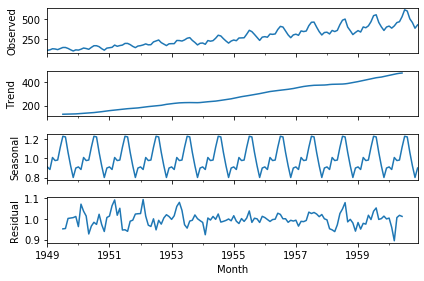

In [36]:
decomposition.plot()
plt.show()

also, we have direct access to all 3 components

In [37]:
type(decomposition.seasonal)

pandas.core.series.Series

In [38]:
decomposition.trend.head(10)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
Name: thousands of passengers, dtype: float64

In [39]:
decomposition.resid.describe()

count    132.000000
mean       0.998236
std        0.033388
min        0.894086
25%        0.982927
50%        0.998219
75%        1.015225
max        1.093970
Name: thousands of passengers, dtype: float64

Well.. but be careful with `seasonal_decompose()`, this can be all very subjective and possibly misleading. Maybe we have a more objective way to look for structure? 

In [40]:
np.random.seed(10)

time_idx = pd.date_range(start='01/01/2010', end='01/08/2018')
df = pd.DataFrame(index = time_idx)


df['trend'] = range(df.index.size)
df['seasonal'] = np.cos((df.index.dayofyear/365 -0.5)*2*np.pi)
df['noise'] = np.random.randn(df.index.size)

df['data'] = (0.1/365)*df.trend + 0.3*df.seasonal + 0.3*df.noise
df.data = df.data.rolling(7, min_periods=1).mean()

#data['seasonal'] = np.cos(data.index.dayofyear*2*np.pi/365 - np.pi)


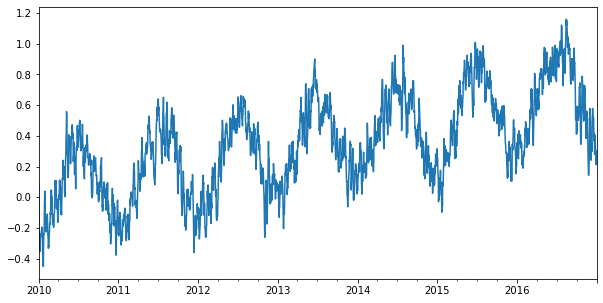

In [41]:
df.data['2010':'2016'].plot(figsize=(10,5))

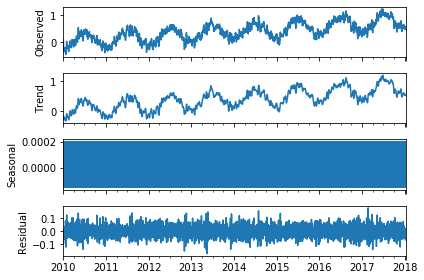

In [42]:
decomposition = seasonal_decompose(df.data, model='aditive')
decomposition.plot();

### Autocorrelation function  

Also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay.  

In the previous section [(seasonal decomposition)](#Seasonal-decomposition) we manually computed autocorrelation to help identify seasonal patterns.  

ACF is so useful, that statsmodel actually comes with functions to calculate and to draw them ([ACF](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html) and [plot ACF](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) documentation). It also gives you something super useful, which are pre-calculated confidence intervals to get an idea of how significant the auto-correlation is.




`from statsmodels.tsa.stattools import acf`  
`from statsmodels.graphics.tsaplots import plot_acf`

In [43]:
acf(airlines, unbiased=True)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\envs\BLU05\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([1.        , 0.95467704, 0.88790688, 0.82384458, 0.774129  ,
       0.73944515, 0.71137419, 0.69677541, 0.69417581, 0.71567822,
       0.75516171, 0.80471118, 0.82952186, 0.78338294, 0.71594837,
       0.65405405, 0.60519959, 0.56664286, 0.53569601, 0.51825101,
       0.51285925, 0.53528635, 0.56948699, 0.61542385, 0.6386278 ,
       0.5977521 , 0.53416841, 0.47704972, 0.43203107, 0.3944146 ,
       0.36441703, 0.34509264, 0.33980156, 0.35909103, 0.39079178,
       0.43013344, 0.4493648 , 0.40822635, 0.34502547, 0.28889875,
       0.23839051])

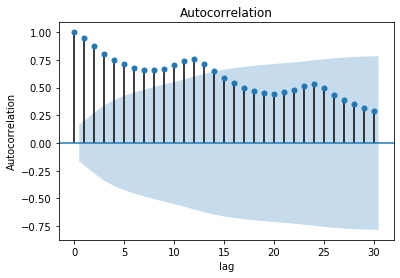

In [44]:
plot_acf(airlines, alpha=.05, lags=30)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

### Partial autocorrelation function  

[PACF](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html) stands for Partial Auto Correlation Function.  

Isn't there something annoying about our previous plot? Lag 12 has an autocorrelation peak. But so does lag 24. So we're kind of "recycling" autocorrelation from the previous year.  

So what we want is to remove the autocorrelation that we've already accounted for, and plot just the "unacounted for" stuff. That's the Partial Autocorrelation Function. 

`from statsmodels.tsa.stattools import pacf`  
`from statsmodels.graphics.tsaplots import plot_pacf`

In [45]:
pacf(airlines)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\envs\BLU05\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


array([ 1.00000000e+00,  9.54677042e-01, -2.65277317e-01,  5.54695472e-02,
        1.08856215e-01,  8.11257853e-02,  4.12540544e-03,  1.56169553e-01,
        1.03708330e-01,  2.88781439e-01,  2.06918048e-01,  2.41129704e-01,
       -1.58004984e-01, -7.18324604e-01, -8.94806410e-02,  2.21605913e-01,
        1.34622533e-01,  1.15615719e-01,  1.94829396e-01,  9.66561845e-02,
       -2.02158680e-01, -9.36381005e-02, -3.45594572e-01, -1.06170206e-01,
        2.77804723e-01,  5.87815922e-02,  9.86624045e-03,  2.37687367e-01,
        9.40568218e-02, -1.47505422e-01, -1.88609051e-01, -2.52801158e-01,
       -2.57153789e-01, -1.40349613e-01,  1.88263087e-01,  1.30686258e-01,
        5.23902189e-01,  6.91426442e-01,  9.91163921e-01,  3.71021065e+01,
       -8.85334119e-01])

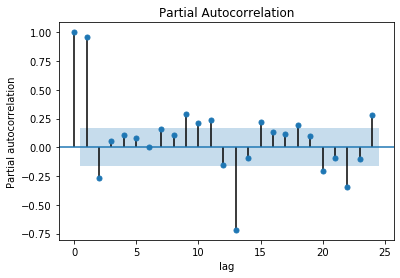

In [46]:
plot_pacf(airlines, alpha=.05, lags=24)
plt.xlabel('lag')
plt.ylabel('Partial autocorrelation')
plt.show()

## Stationarity  

The concept of autocorrelation is essential for modelling time series, but at least as important is understanding what is stationarity.  

From https://en.wikipedia.org/wiki/Stationary_process#Weak_or_wide-sense_stationarity  

> *In mathematics and statistics, a **stationary process** is a **stochastic process whose unconditional joint probability distribution does not change when shifted in time**. Consequently, parameters such as mean and variance also do not change over time.*

> Since stationarity is an assumption underlying many statistical procedures used in time series analysis, **non-stationary data are often transformed to become stationary**.

However, remember this: whatever transformation you do to your timeseries in your attempt to make it stationary should be one you can reverse later.

**Stabilize Variance**  

First, we should stabilize the variance so that it is approximatelly constant over time. The most common way to do that, is to **apply the log transformation**.  

We have done exactly that when assessing if the time series is [multiplicative or additive](#multiplicative_or_additive)

**Removing trend**  

The next step is to remove the trend, so that the means of the timeseries is aproximatelly constant over time. A trivial way to remove the trend is to use the **difference** [(Series.diff())](https://pandas.pydata.org/pandas-docs/version/0.17/generated/pandas.Series.diff.html) beween consecutive observations, instead of the observations themselves. 


Transform non-stationary time series into stationary...

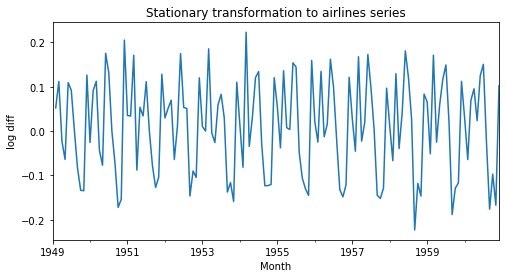

In [47]:
airlines_log_diff = airlines.apply(np.log).diff()

airlines_log_diff.plot(figsize=(8,4), label='airlines passangers')
plt.ylabel('log diff')
plt.title('Stationary transformation to airlines series')
plt.show()

Reverse transformation...

In [48]:
airlines2 = (airlines_log_diff + airlines.apply(np.log).shift(1)).apply(np.exp)
(airlines2- airlines).describe()

count    1.430000e+02
mean     7.453245e-15
std      7.947836e-14
min     -1.705303e-13
25%     -4.263256e-14
50%      0.000000e+00
75%      5.684342e-14
max      2.273737e-13
Name: thousands of passengers, dtype: float64

### Evaluating stationarity  

Is it stationary? It "looks stationary", but...   

The Dickey-Fuller test has the null hypothesis that the [Unit Root](https://en.wikipedia.org/wiki/Unit_root) is present. If the unit root isn't present the timeseries can be assumed to be stationary. 

Perform Dickey-Fuller test:  
`from statsmodels.tsa.stattools import adfuller`

In [49]:
try: 
    adfuller(airlines_log_diff)
except Exception as e:
    print('Not working! And here is why: %s' % e)
    


Not working! And here is why: exog contains inf or nans


First the original series...

In [50]:
adfstat, pvalue, usedlag, nobs, critvalues, icbest =  adfuller(airlines)

print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: 0.82
pvalue:    0.992


Clearly not stationary! Now after the log diff transformation...

In [51]:
adfstat, pvalue, usedlag, nobs, critvalues, icbest =  adfuller(airlines_log_diff.dropna())

print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -2.72
pvalue:    0.071


The p value is low, but not as low as we normally like it to be. We can't reject that we have unit root at a 95% confidence interval, which is a good rule of thumb. For that, we'd need to have a p value < 0.05. But since this is just an example, we can leave as it is. 

If we really wanted to have a more stationary time series we could use more sophisticated ways to get rid of the trend (subtracting the rolling mean) or even diff again.

## ARIMA -  AR (Auto Regressive) I (Integrated) MA (Moving Average)  

ARIMA model class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html).  
ARIMA results class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.html#statsmodels.tsa.arima_model.ARIMAResults).  

More detailed information [here](https://people.duke.edu/~rnau/411arim.htm).

We want to use the model with a stationary time series, so we are going to **stabilize the variance** so that it is approximatelly constant over time. Then we are going to **remove the trend**. Exactly as before we will use the log diff transformation.

In [52]:
airlines_log_diff = airlines.apply(np.log).diff()

About the ARIMA model API, it elegantly depends only on 3 parameters: 

> `ARIMA(p,d,q)`

### 1.1 Auto regressive 

The first of our 3 parameters, `p`, is the "number of auto-regressive terms". An auto-regressive model means that: 
> ***“The value at a particular time depends on the value at the previous times (+ error)”***
  
There's a rule of thumb to use the **partial auto-correlation function** and choose the lag before the first lag within the confidence interval. For example, lag 2 is already within the confidence interval (not completely, but let's consider so) so we'll go with lag 1, thus `p`=1.

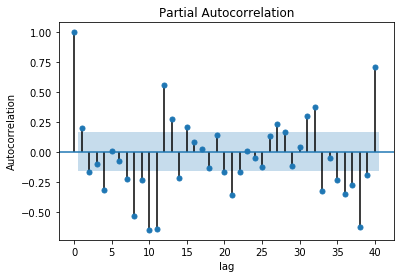

In [53]:
plot_pacf(airlines_log_diff.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

### 1.2 Integrated 

The "integrated" part of the name simply means that we take the diff between consecutive periods to make the time series stationary. We've already done this ahead of time (because we needed it for our ACF and PACF plots), but you can also leave it as a hyper parameter and tune it later. 


### 1.3 Moving Average 

The last of our 3 parameters, `q`, is the "number of moving average terms". 

The logic here is similar to the one we used for `p`, but instead of predicting values with lagged values, we are predicting errors with lagged errors. 

The MA terms are lagged forecast errors. In this model, what predicts `x(t)` is `e(t-1)`, `e(t-2)`, ..., where `e(i)` is the difference between the moving average at the ith instant and the actual value.

The rule of thumb for setting `q` is to use the ACF. The reasons are not trivial, and are well explained in [this fantastic StackExchange post](https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa), if you are interested in digging deeper. 

If not, just remember: 
> For `p` use the PACF  
> For `q` use the ACF. 

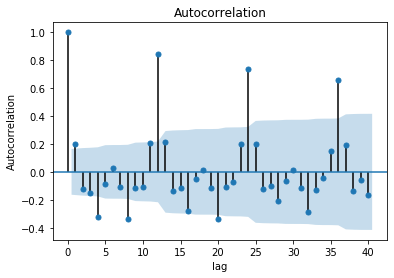

In [54]:
plot_acf(airlines_log_diff.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

As before, lags 2 is already within the confidence interval, so we'll just go with `q`=1

### Running the model

In [55]:
# from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(airlines_log_diff.dropna().values, order=(1, 0, 1))
results_ARIMA = model.fit()
predictions = results_ARIMA.predict()

In [56]:
type(predictions)

numpy.ndarray

In [57]:
# quick adjustment to plot sizes for clarity 
plt.rcParams["figure.figsize"] = (10,5)

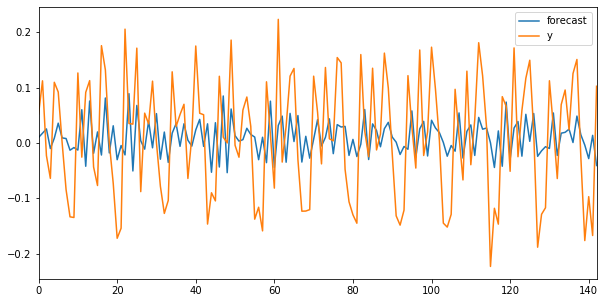

In [58]:
results_ARIMA.plot_predict()
plt.show()

A few differences between the statsmodels' ARIMA and sklearn:  

1. We pass the data straight to the model (sklearn example `model = LinearRegression()`).
2. We used `.values` to get the numpy array instead of the pandas series (in sklearn `X` and `y` are also numpy arrays).
3. We called `fit` without any parameters (sklearn example `model.fit(X, y)`)
4. The model isn't fit in place, we have to grab the results with a results (sklearn example `y_hat = model.predict(X)`)
5. The predictions are a numpy array (here is the same, sklearn `model.predict(X)` returns a numpy array as well)

In [59]:
# Obtaining predictions as a pandas Series
prediction_ARIMA_log_diff = pd.Series(results_ARIMA.predict(), index=airlines.index[1:])

# Recover from transformation
prediction_ARIMA_log = prediction_ARIMA_log_diff + airlines.apply(np.log).shift(1)
prediction_ARIMA = prediction_ARIMA_log.apply(np.exp)

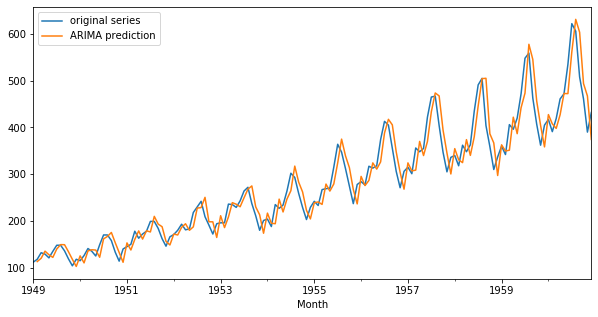

In [60]:
airlines.plot(label='original series')
prediction_ARIMA.plot(label='ARIMA prediction')
plt.legend()
plt.show()

## SARIMAX -  S (Seasonal) ARIMA X (with Exogenous variable)


SARIMAX Introduction [here](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html?highlight=predicted_mean).  
SARIMAX model class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).  
SARIMAX results class [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.html#statsmodels.tsa.statespace.mlemodel.MLEResults).  

What are the parameters? 

The ones below we already know. **Also note that now we're going to use d=1 to avoid having to difference the time series, and then transforming it back**. Also note that we still have to log the data, since SARIMAX can't do that by itself.
> p = 1  
> d = 1  
> q = 1  

But now we have a second bunch. The first 3 are analagous to the previous ones, but for the seasonal part. There are also guidelines on how to chose them, but for now we'll just use the following: 
> P = 1  
> D = 1  
> Q = 1  

The last new parameter, `S`, is an integer giving the periodicity (number of periods in season). 
We normally have a decent intuition for this parameter: 
- If we have daily data and suspect we may have weekly trends, we may want S = 7. 
- If the data is monthly and we think the time of the year may count, maybe try S = 12. 


### Running the model

In [61]:
airlines_log = airlines.apply(np.log)

# Initialize the model
model = SARIMAX(airlines_log,                 # <-- holy crap just passed it pandas? No ".values"? No .diff?
                order=(1, 1, 1),              # <-- keeping our order as before
                seasonal_order=(1, 0, 1, 12)) # <-- We'll get into how we found these hyper params

# Fit the model
results_SARIMAX = model.fit(maxiter=100)

# Get predictions
pred = results_SARIMAX.get_prediction()

# get prediction mean value as pandas.Series
predictions = pred.predicted_mean

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\envs\BLU05\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [62]:
type(pred)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [63]:
type(pred.predicted_mean)

pandas.core.series.Series

In [64]:
print(pred.predicted_mean.apply(np.exp).head())
print(airlines.head())

1949-01-01      1.000000
1949-02-01    111.999999
1949-03-01    116.587778
1949-04-01    127.003950
1949-05-01    126.269576
Freq: MS, dtype: float64
Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: thousands of passengers, dtype: float64


A few differences between SARIMAX, ARIMA and sklearn:  

1. We pass the data straight to the model (same as ARIMA, sklearn example `model = LinearRegression()`).
2. We the time seires straight to the model as a pandas Series (in ARIMA we used `.values` and in sklearn `X` and `y` are also numpy arrays).
3. We called `fit` without any parameters (same as ARIMA, sklearn example `model.fit(X, y)`)
4. The model isn't fit in place, we have to grab the results with a results (same as ARIMA, sklearn example `y_hat = model.predict(X)`)
5. The predictions are a strange object (ARIMA `results.predict()` returns a numpy array as well as sklearn `model.predict(X)`)
6. However, if we use `pred.predicted_mean` we get a pandas Series with indices already in place!

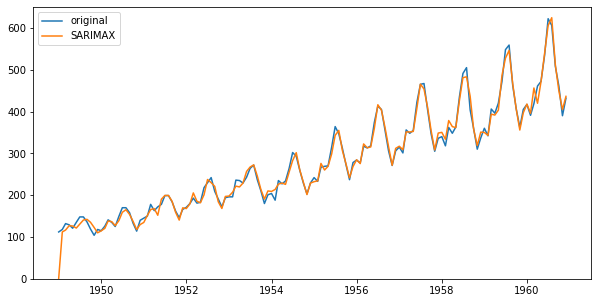

In [65]:
predictions_SARIMAX = predictions.apply(np.exp)

plt.figure(figsize=(10, 5))
plt.plot(airlines, label='original')
plt.plot(predictions_SARIMAX, label='SARIMAX')
plt.legend()
plt.ylim((0, 650))
plt.show();

### Validation and evaluation

The standard metric for timeseries claisscal models is the **AIC (Akaike information criterion)**, which is a metric that will simutaneously measure how well the model fits the data, but will control for how complex the model is. If the model is very complex, the expectation on how well it must fit the data will also go up. It is therefore useful for comparing models.

In [66]:
results_ARIMA.aic

-241.6077140261197

In [67]:
results_SARIMAX.aic

-498.8075617892029

Smaller is better, so it seems that SARIMAX performed better than ARIMA!

Another possible criteria for evaluation is to use de **MAE (mean-absolute-error)**. For that we can use scikit learn [mean_absolute_error()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

`from sklearn.metrics import mean_absolute_error`

In [68]:
mean_absolute_error(airlines[1:], prediction_ARIMA[1:])

24.49837914140647

In [69]:
mean_absolute_error(airlines[1:], predictions_SARIMAX[1:])

8.173645414436864

Also with this criteria SARIMAX performed better than ARIMA.  

Notice that **we must drop the first element** because it cannot be predicted by the models!

There are also other metrics, such as R², but for that we'd need to create a validation set to avoid overfitting. Since AIC already penalizes complexity, we can use it without a validation set.